In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
from glob import glob

from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
import tensorflow as tf
import cv2
import os
import pickle
import numpy as np

In [2]:
from keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import add
from tensorflow.keras.layers import AveragePooling2D,GlobalAveragePooling2D,Concatenate,Lambda
import sklearn.metrics as metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend
from tensorflow.keras.optimizers import Adam

In [17]:
BATCH_SIZE = 24
image_size = 200

In [4]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory('content', shuffle=True,image_size=(image_size, image_size),seed=100, validation_split=0.2,subset='training')
val_dataset = tf.keras.preprocessing.image_dataset_from_directory('content', shuffle=True,image_size=(image_size, image_size), seed=100,validation_split=0.2,subset='validation')

Found 1634 files belonging to 14 classes.
Using 1308 files for training.
Found 1634 files belonging to 14 classes.
Using 326 files for validation.


2023-02-16 01:23:28.643116: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
class_names = train_dataset.class_names
class_names

['Appliqued',
 'Checked',
 'Colour Blocked',
 'Colour%20blocked',
 'Dyed',
 'Embellished',
 'Embroidered',
 'Heathered',
 'Lace',
 'Patterned%20Knit',
 'Patterned%20weave',
 'Striped',
 'Textured',
 'Washed']

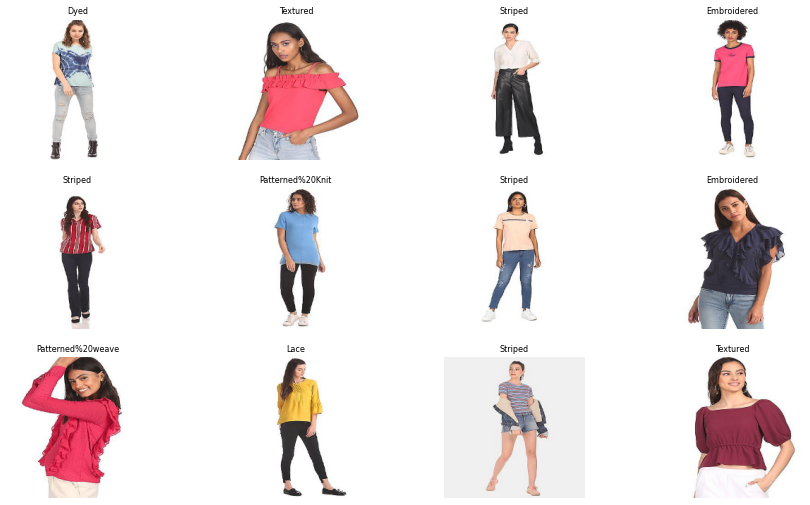

In [9]:
plt.figure(figsize=(15,15))
for image_batch, label_batch in train_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(5,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]], fontsize=8)
        plt.axis("off")

In [10]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model

resnet = ResNet50(include_top=False, weights = 'imagenet', input_shape= (image_size, image_size, 3), pooling = 'max')

output = resnet.layers[-1].output
output = tf.keras.layers.Flatten()(output)
resnet = Model(resnet.input, output)

res_name = []
for layer in resnet.layers:
    res_name.append(layer.name)

In [11]:
res_name[:-22]

['input_1',
 'conv1_pad',
 'conv1_conv',
 'conv1_bn',
 'conv1_relu',
 'pool1_pad',
 'pool1_pool',
 'conv2_block1_1_conv',
 'conv2_block1_1_bn',
 'conv2_block1_1_relu',
 'conv2_block1_2_conv',
 'conv2_block1_2_bn',
 'conv2_block1_2_relu',
 'conv2_block1_0_conv',
 'conv2_block1_3_conv',
 'conv2_block1_0_bn',
 'conv2_block1_3_bn',
 'conv2_block1_add',
 'conv2_block1_out',
 'conv2_block2_1_conv',
 'conv2_block2_1_bn',
 'conv2_block2_1_relu',
 'conv2_block2_2_conv',
 'conv2_block2_2_bn',
 'conv2_block2_2_relu',
 'conv2_block2_3_conv',
 'conv2_block2_3_bn',
 'conv2_block2_add',
 'conv2_block2_out',
 'conv2_block3_1_conv',
 'conv2_block3_1_bn',
 'conv2_block3_1_relu',
 'conv2_block3_2_conv',
 'conv2_block3_2_bn',
 'conv2_block3_2_relu',
 'conv2_block3_3_conv',
 'conv2_block3_3_bn',
 'conv2_block3_add',
 'conv2_block3_out',
 'conv3_block1_1_conv',
 'conv3_block1_1_bn',
 'conv3_block1_1_relu',
 'conv3_block1_2_conv',
 'conv3_block1_2_bn',
 'conv3_block1_2_relu',
 'conv3_block1_0_conv',
 'conv3_

In [12]:
set_trainable = False
for layer in resnet.layers:
    if layer.name in res_name[-22:]:
        set_trainable = True
    if set_trainable:
        layer.trainable = True

    else:
        layer.trainable = False

In [13]:
resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [14]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout

model6 = Sequential()
model6.add(resnet)
model6.add(Dense(2048, activation='relu'))
model6.add(Dense(1024, activation='relu'))
model6.add(Dense(512, activation='relu'))
# model6.add(Dense(256, activation='relu'))
model6.add(Dense(128, activation='relu'))
model6.add(Dense(15, activation='softmax'))
model6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dense_3 (Dense)             (None, 128)               65664     
                                                                 
 dense_4 (Dense)             (None, 15)                1935      
                                                                 
Total params: 30,474,639
Trainable params: 15,818,255
No

In [15]:
model6.compile(optimizer = 'adam', 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

In [18]:
EPOCHS = 25
history6 = model6.fit(
    train_dataset,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    validation_data = val_dataset,
    verbose = 1,
)

Epoch 1/25
41/41 [==============================] - 129s 3s/step - loss: 4.0764 - accuracy: 0.3096 - val_loss: 9.1912 - val_accuracy: 0.2485
Epoch 2/25
41/41 [==============================] - 133s 3s/step - loss: 1.6014 - accuracy: 0.4977 - val_loss: 3.0342 - val_accuracy: 0.3712
Epoch 3/25
41/41 [==============================] - 138s 3s/step - loss: 1.0870 - accuracy: 0.6498 - val_loss: 1.7003 - val_accuracy: 0.5613
Epoch 4/25
41/41 [==============================] - 147s 4s/step - loss: 0.6096 - accuracy: 0.8089 - val_loss: 1.2825 - val_accuracy: 0.6626
Epoch 5/25
41/41 [==============================] - 153s 4s/step - loss: 0.4025 - accuracy: 0.8677 - val_loss: 0.7539 - val_accuracy: 0.7577
Epoch 6/25
41/41 [==============================] - 169s 4s/step - loss: 0.2276 - accuracy: 0.9343 - val_loss: 1.0119 - val_accuracy: 0.7699
Epoch 7/25
41/41 [==============================] - 242s 6s/step - loss: 0.1740 - accuracy: 0.9450 - val_loss: 0.5610 - val_accuracy: 0.8374
Epoch 8/25
41

In [19]:
scores = model6.evaluate(val_dataset)

11/11 [==============================] - 16s 1s/step - loss: 0.2828 - accuracy: 0.9479


In [20]:
acc = history6.history['accuracy']
val_acc = history6.history['val_accuracy']

loss = history6.history['loss']
val_loss = history6.history['val_loss']

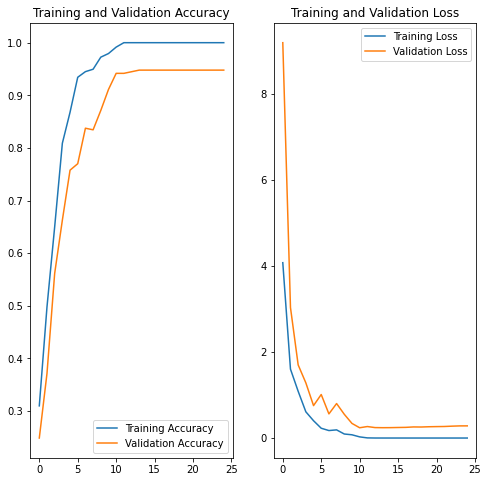

In [22]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [73]:
content_dir = './content'

In [55]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [78]:
from tensorflow.keras.preprocessing.image import load_img
def predict2(model, img_path):
    img = load_img(os.path.join(content_dir, img_path), target_size=(image_size, image_size))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [25]:
model6.save('model.h5')

/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


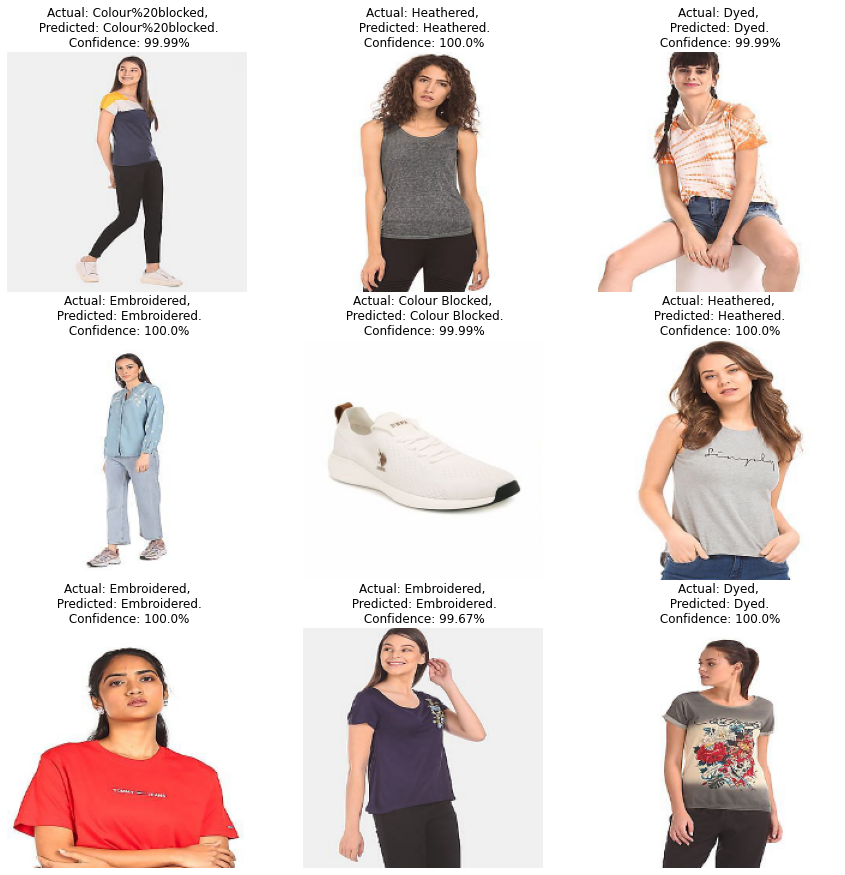

In [70]:
plt.figure(figsize=(15, 15))
for images, labels in val_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model6, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [107]:
dress_data = pd.read_csv('data_dresses.csv')

In [91]:
dress_data.head()

,img_path,pattern,dress_description,image_link
0,Striped/Striped1.jpg,Striped,Aeropostale Women Cream Striped Off-Shoulder C...,https://cdn01.nnnow.com/web-images/medium/styl...
1,Striped/Striped2.jpg,Striped,Aeropostale Women Cream Striped Off-Shoulder C...,https://cdn02.nnnow.com/web-images/medium/styl...
2,Striped/Striped3.jpg,Striped,SUGR Women Fuchsia Round Neck Short Sleeves St...,https://cdn11.nnnow.com/web-images/medium/styl...
3,Striped/Striped4.jpg,Striped,SUGR Women Fuchsia Round Neck Short Sleeves St...,https://cdn04.nnnow.com/web-images/medium/styl...
4,Striped/Striped5.jpg,Striped,U.S. Polo Assn. Women Grey Bateau Neck Stylize...,https://cdn05.nnnow.com/web-images/medium/styl...


In [59]:
image = tf.keras.preprocessing.image.load_img('./content/Striped/Striped1.jpg', target_size=(image_size, image_size))

In [64]:
input_arr = tf.keras.preprocessing.image.img_to_array(image)

In [72]:
train_dataset.take(1)

<TakeDataset shapes: ((None, 200, 200, 3), (None,)), types: (tf.float32, tf.int32)>

In [87]:
len(dress_data)

1618

In [105]:
len(dress_data)

10

In [109]:
predict_list = []
confidence_list = []
for i in range(len(dress_data)):
    img_path = dress_data['img_path'][i]
    predicted_class, confidence = predict2(model6, img_path)
    actual_class = dress_data['pattern'][i]
    predict_list.append(predicted_class)
    confidence_list.append(confidence)
    
print(predict_list)

dress_data['predictions'] = predict_list
dress_data['confidence'] = confidence_list
# dress_data['predictions'] = dress_data['predictions'].append(pd.Series(predict_list))
print(dress_data.head(5))

['Striped', 'Embroidered', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Textured', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Striped', 'Str

In [110]:
dress_data.to_csv('final_prediction.csv')

In [112]:
dress_data.head(10)

,img_path,pattern,dress_description,image_link,predictions,confidence
0,Striped/Striped1.jpg,Striped,Aeropostale Women Cream Striped Off-Shoulder C...,https://cdn01.nnnow.com/web-images/medium/styl...,Striped,100.00
1,Striped/Striped2.jpg,Striped,Aeropostale Women Cream Striped Off-Shoulder C...,https://cdn02.nnnow.com/web-images/medium/styl...,Embroidered,68.08
2,Striped/Striped3.jpg,Striped,SUGR Women Fuchsia Round Neck Short Sleeves St...,https://cdn11.nnnow.com/web-images/medium/styl...,Striped,100.00
3,Striped/Striped4.jpg,Striped,SUGR Women Fuchsia Round Neck Short Sleeves St...,https://cdn04.nnnow.com/web-images/medium/styl...,Striped,100.00
4,Striped/Striped5.jpg,Striped,U.S. Polo Assn. Women Grey Bateau Neck Stylize...,https://cdn05.nnnow.com/web-images/medium/styl...,Striped,100.00
5,Striped/Striped6.jpg,Striped,U.S. Polo Assn. Women Grey Bateau Neck Stylize...,https://cdn16.nnnow.com/web-images/medium/styl...,Striped,100.00
6,Striped/Striped7.jpg,Striped,U.S. Polo Assn. Women White And Pink Mandarin ...,https://cdn19.nnnow.com/web-images/medium/styl...,Striped,100.00
7,Striped/Striped8.jpg,Striped,U.S. Polo Assn. Women White And Pink Mandarin ...,https://cdn06.nnnow.com/web-images/medium/styl...,Striped,100.00
8,Striped/Striped9.jpg,Striped,U.S. Polo Assn. Women Fuchsia V-Neck Self Desi...,https://cdn05.nnnow.com/web-images/medium/styl...,Striped,100.00
9,Striped/Striped10.jpg,Striped,U.S. Polo Assn. Women Fuchsia V-Neck Self Desi...,https://cdn08.nnnow.com/web-images/medium/styl...,Striped,99.97
